In [1]:
# Core libraries
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# PyTorch
import torch
import torch.utils.data
import torchvision
from torchvision.transforms import functional as F

# Image handling
from PIL import Image
import cv2  # for drawing masks (optional but useful)

# XML parsing
import xml.etree.ElementTree as ET

from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.patches as patches

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [51]:
# Dataset Preparation
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms=None):
        """
        Args:
            root_dir (str): path to dataset split (train/valid/test folder)
            transforms (callable, optional): image transformations
        """
        self.root_dir = root_dir
        self.transforms = transforms

        # Collect all image + annotation file paths
        self.imgs = sorted(glob.glob(os.path.join(root_dir, "*.jpg")))
        self.annots = sorted(glob.glob(os.path.join(root_dir, "*.xml")))

        assert len(self.imgs) == len(self.annots), "Mismatch between images and annotations"
        # Counters for debug
        self.skipped, self.used = 0, 0

        # --- Build class list automatically ---
        label_set = set()
        for annot_path in self.annots:
            tree = ET.parse(annot_path)
            root = tree.getroot()
            for obj in root.findall("object"):
                name = obj.find("name").text.strip()
                label_set.add(name)

        self.classes = ["__background__"] + sorted(label_set)
        print(f"[INFO] Found {len(self.classes)} classes: {self.classes[:]}")

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        annot_path = self.annots[idx]
    
        # Load image
        img = Image.open(img_path).convert("RGB")
        width, height = img.size
    
        # Parse XML
        tree = ET.parse(annot_path)
        root = tree.getroot()
    
        boxes, labels, masks = [], [], []
    
        for obj in root.findall("object"):
            name = obj.find("name").text
            label = self.classes.index(name)
    
            # --- Bounding box ---
            bndbox = obj.find("bndbox")
            xmin = int(float(bndbox.find("xmin").text))
            ymin = int(float(bndbox.find("ymin").text))
            xmax = int(float(bndbox.find("xmax").text))
            ymax = int(float(bndbox.find("ymax").text))
    
            # If bbox is invalid → skip this object
            if xmax <= xmin or ymax <= ymin:
                print(f"[SKIP] Label and its Polygon due to irregular dims in Image: {os.path.basename(img_path)}")
                continue
    
            # --- Polygon mask ---
            polygon = obj.find("polygon")
            mask = np.zeros((height, width), dtype=np.uint8)
            if polygon is not None:
                pts = []
                for i in range(1, len(polygon) // 2 + 1):
                    x = float(polygon.find(f"x{i}").text)
                    y = float(polygon.find(f"y{i}").text)
                    pts.append([x, y])
                pts = np.array([pts], dtype=np.int32)
    
                if pts.shape[1] > 2:  # polygon must have at least a triangle - < 3
                    cv2.fillPoly(mask, pts, 1)
            else:
                mask[ymin:ymax, xmin:xmax] = 1
    
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)
            masks.append(mask)
    
        # If no valid objects, skip image
        if len(boxes) == 0 or len(masks) == 0:
            print(f"[SKIP] Image: {os.path.basename(img_path)} | Annotation: {os.path.basename(annot_path)}")
            self.skipped += 1
            return self.__getitem__((idx + 1) % len(self))
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
    
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }
    
        # Convert image → tensor
        img = F.to_tensor(img)
    
        if self.transforms:
            img = self.transforms(img)

        # Debug print
        if img.shape[0] != 3:
            print(f"Warning: Image {self.imgs[idx]} has {img.shape[0]} channels")

        self.used += 1
        if (self.used + self.skipped) % len(self.imgs) == 0:
            print(f"[INFO] Used: {self.used} | Skipped: {self.skipped}")
        
        return img, target

In [5]:
# Data loader
def collate_fn(batch):
    """
    Custom collate function for detection models.
    Keeps list of images and list of targets (dicts).
    """
    return tuple(zip(*batch))

In [3]:
# Datasets
train_dataset = CustomDataset("/kaggle/input/mask-rcnn-instance-segmentation/train")
test_dataset  = CustomDataset("/kaggle/input/mask-rcnn-instance-segmentation/test")

[INFO] Found 14 classes: ['__background__', 'com-dep', 'dan-bau', 'dan-guitar', 'dan-nguyet', 'dan-nhi', 'dan-sen', 'dan-tranh', 'dan-ty-ba', 'dua-bo', 'ghe-ngo', 'micro', 'sao-truc', 'thuyen-buon']
[INFO] Found 14 classes: ['__background__', 'com-dep', 'dan-bau', 'dan-guitar', 'dan-nguyet', 'dan-nhi', 'dan-sen', 'dan-tranh', 'dan-ty-ba', 'dua-bo', 'ghe-ngo', 'micro', 'sao-truc', 'thuyen-buon']


In [6]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, list(range(0, len(train_dataset), 3))), batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dataset, list(range(0, len(test_dataset), 3))), batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [7]:
# Print the size of samples
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 9906
Test samples: 539


In [33]:
# Generate distinct color each class
def get_class_color(label_index):
    """
    Return a distinct color for a given class index.
    Cycles through a fixed palette so colors are consistent across runs.
    
    Args:
        label_index (int): class index (0..num_classes-1)
    Returns:
        tuple: (R, G, B) values in range [0,1]
    """
    # Distinct base colors (Matplotlib style single-letter codes + extras)
    distinct_colors = [
        'r', 'g', 'b', 'c', 'm', 'y', 'k',
        '#FF7F0E', '#1F77B4', '#2CA02C', '#D62728',
        '#9467BD', '#8C564B'  # enough for 13 classes
    ]
    
    # Select color deterministically
    color = distinct_colors[label_index % len(distinct_colors)]
    
    # Convert matplotlib-style color to RGB tuple
    rgb = plt.colors.to_rgb(color) if hasattr(plt, "colors") else plt.matplotlib.colors.to_rgb(color)
    
    return rgb

In [34]:
# Function to visualize a sample with masks, labels, boxes
def visualize_sample(img, target, class_names, show=True):
    """
    Visualize an image with:
    - Original image
    - Annotation (masks + boxes + labels)
    - Overlay (image + annotation)
    """

    # Convert tensor -> numpy uint8
    if isinstance(img, torch.Tensor):
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np * 255).astype(np.uint8)
    else:
        img_np = np.array(img)

    boxes = target["boxes"].cpu().numpy()
    labels = target["labels"].cpu().numpy()
    masks = target["masks"].cpu().numpy()

    # Start with blank annotation canvas
    annotation_canvas = np.zeros_like(img_np, dtype=np.uint8)

    # Overlay copy
    overlay_canvas = img_np.copy()

    # Unique color per label
    unique_labels = np.unique(labels)
    color_map = {lbl: tuple(int(c * 255) for c in random_color(lbl)) for lbl in unique_labels}

    for i, box in enumerate(boxes):
        label = labels[i]
        mask = masks[i]

        color = color_map[label]

        # --- Draw mask ---
        colored_mask = np.zeros_like(img_np, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]

        annotation_canvas = cv2.addWeighted(annotation_canvas, 1.0, colored_mask, 0.5, 0)
        overlay_canvas = cv2.addWeighted(overlay_canvas, 1.0, colored_mask, 0.5, 0)

        # --- Draw bounding boxes + labels ---
        xmin, ymin, xmax, ymax = box.astype(int)

        # Annotation-only
        cv2.rectangle(annotation_canvas, (xmin, ymin), (xmax, ymax), color, 2)
        cv2.putText(annotation_canvas, class_names[label], (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Overlay
        cv2.rectangle(overlay_canvas, (xmin, ymin), (xmax, ymax), color, 2)
        cv2.putText(overlay_canvas, class_names[label], (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Plot row: original | annotation | overlay
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(img_np)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(overlay_canvas)
    ax[1].set_title("Overlay")
    ax[1].axis("off")
    
    ax[2].imshow(annotation_canvas)
    ax[2].set_title("Annotation Only")
    ax[2].axis("off")

    plt.tight_layout()
    if show:
        plt.show()
    plt.close()

In [68]:
# # Pick one sample from train/test
# img, target = train_dataset[560]
# visualize_sample(img, target, train_dataset.classes)

In [43]:
# Visualize samples from a dataset
def visualize_dataset(dataset, name="Dataset", max_samples=5):
    print(f"Visualizing {name} (up to {max_samples} samples)")
    for i in range(min(len(dataset), max_samples)):
        img, target = dataset[np.random.randint(len(dataset))]
        print(f"Sample {np.random.randint(len(dataset))+1}/{len(dataset)} - {name}")
        visualize_sample(img, target, dataset.classes)

Visualizing Train Set (up to 3 samples)
Sample 4151/9906 - Train Set


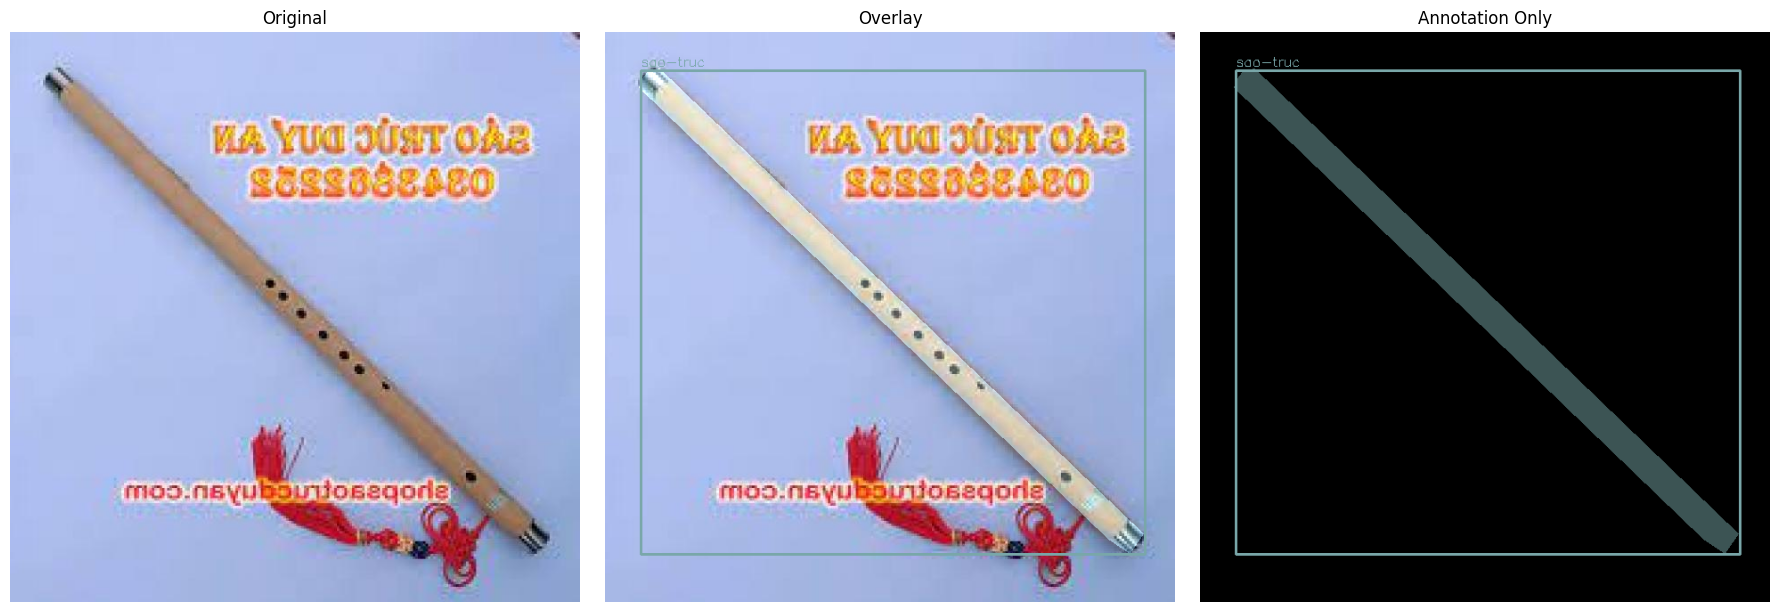

Sample 8933/9906 - Train Set


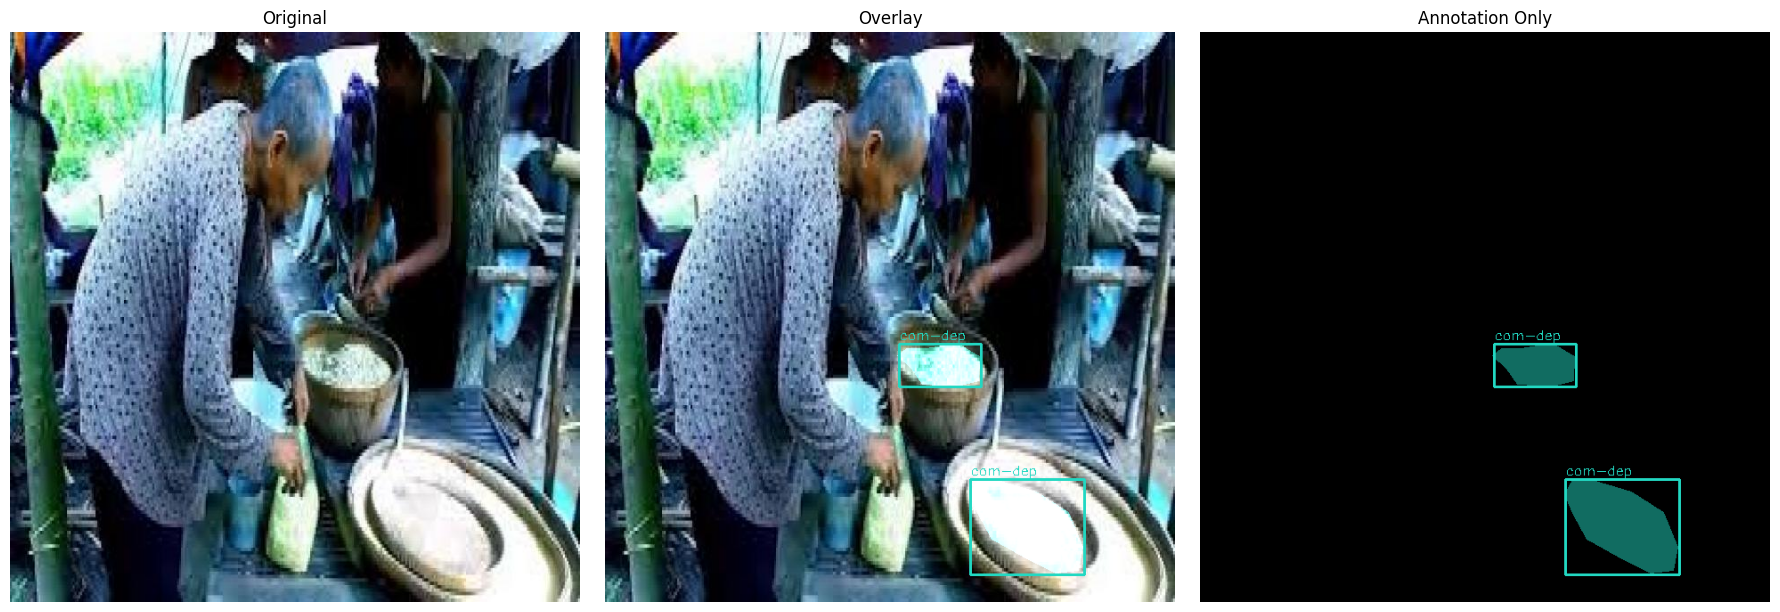

Sample 8162/9906 - Train Set


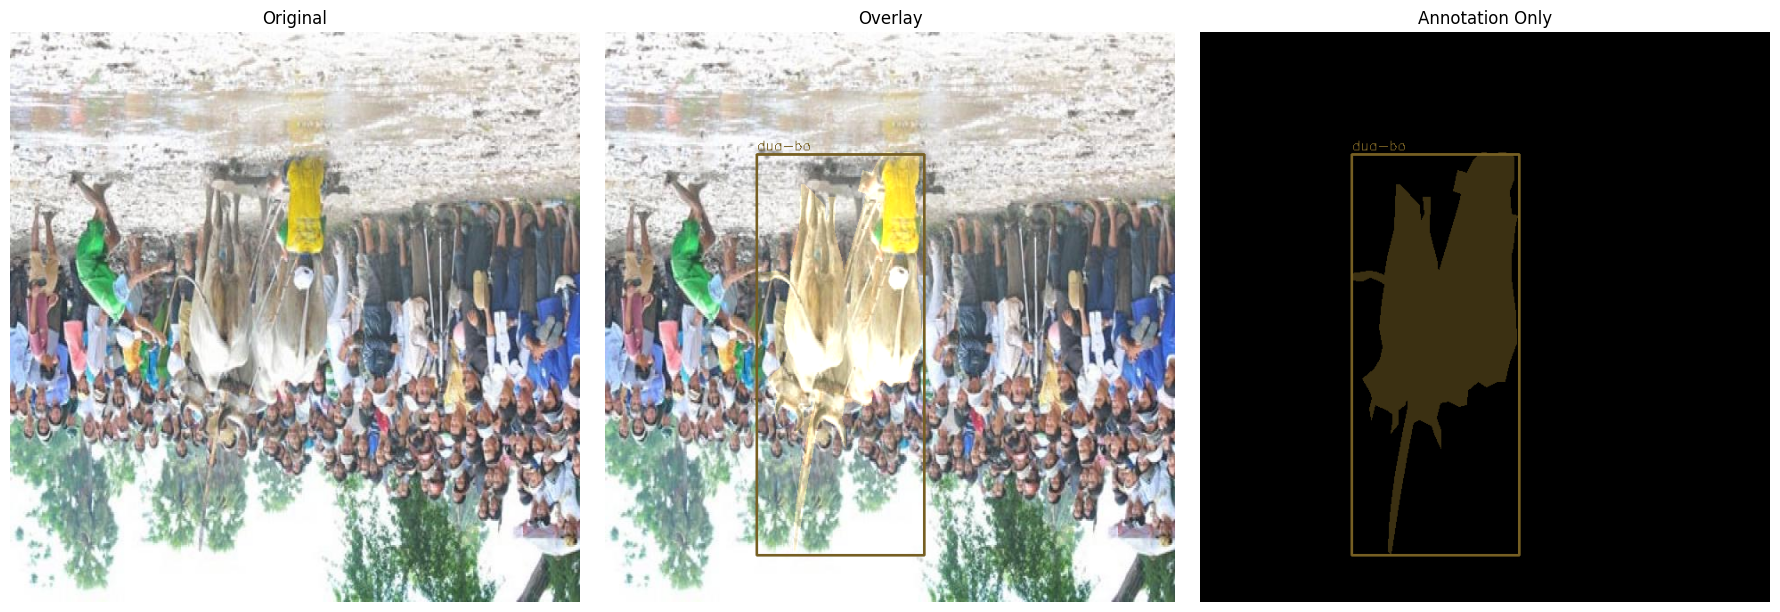

Visualizing Test Set (up to 3 samples)
Sample 149/539 - Test Set


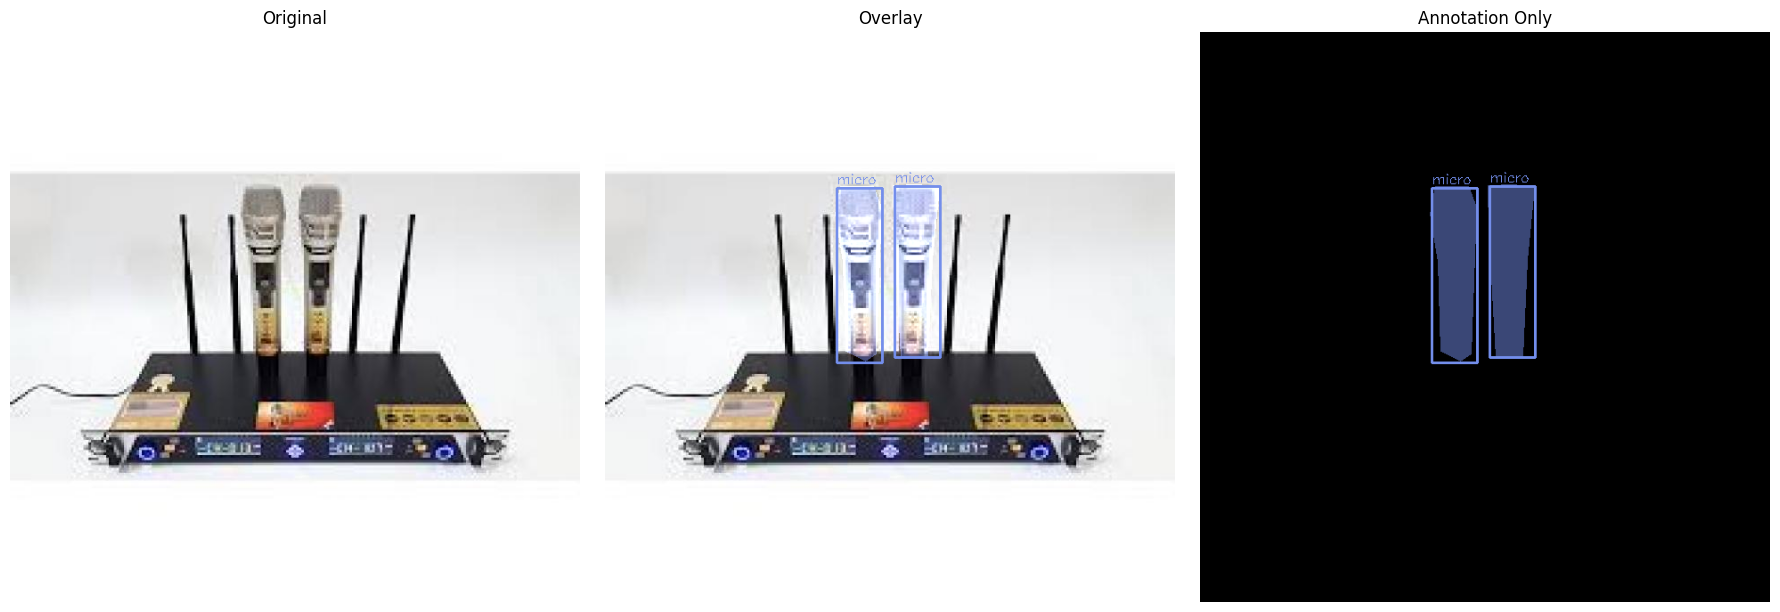

Sample 197/539 - Test Set


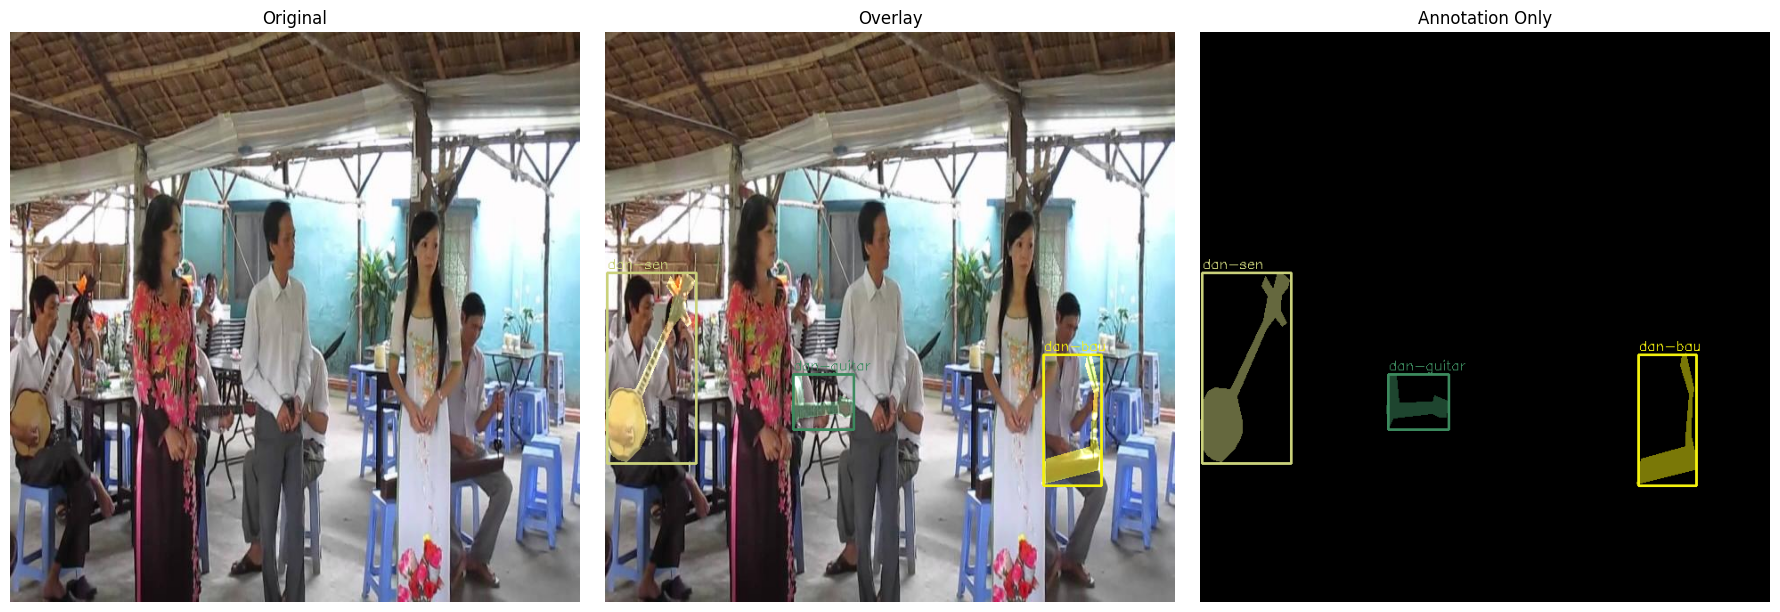

Sample 481/539 - Test Set


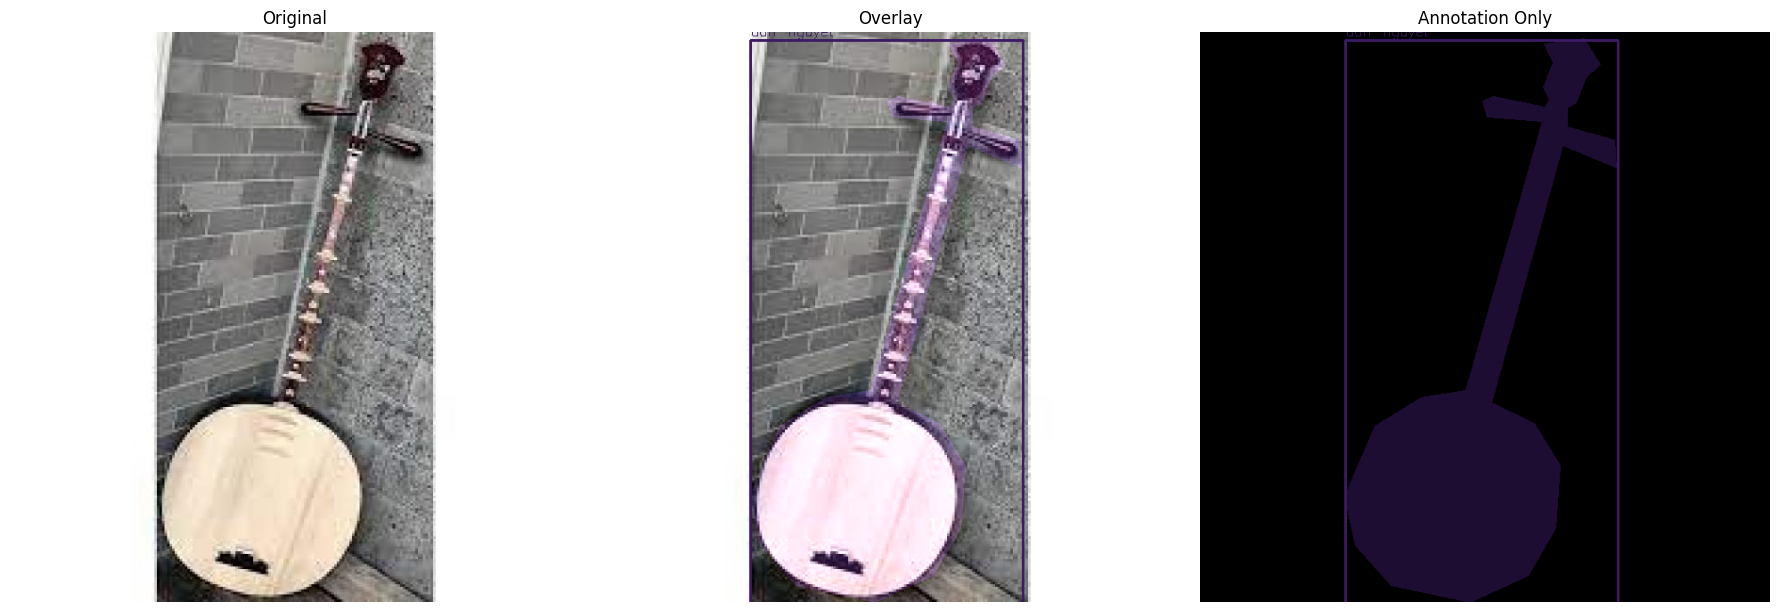

In [69]:
# Visualize training samples
visualize_dataset(train_dataset, name="Train Set", max_samples=3)
# Visualize test samples
visualize_dataset(test_dataset, name="Test Set", max_samples=3)

In [70]:
# Debug samples BEFORE training
i = 100
# for i in range(len(train_dataset)-1):
img, target = train_dataset[i]
print(f"\n[DEBUG] Sample {i}")
print("Image shape:", img.shape)
print("Boxes shape:", target["boxes"].shape)
print("Labels shape:", target["labels"].shape)
print("Masks shape:", target["masks"].shape)
print("Image:", img)
print("\nBoxes:", target["boxes"])
print("\nLabels:", target["labels"])
print("\nMasks:", target["masks"])


[DEBUG] Sample 100
Image shape: torch.Size([3, 640, 640])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Masks shape: torch.Size([1, 640, 640])
Image: tensor([[[0.3529, 0.3529, 0.3451,  ..., 0.3098, 0.3176, 0.3176],
         [0.3529, 0.3529, 0.3451,  ..., 0.3098, 0.3176, 0.3176],
         [0.3529, 0.3529, 0.3451,  ..., 0.3098, 0.3176, 0.3176],
         ...,
         [0.3961, 0.3961, 0.4000,  ..., 0.3765, 0.3804, 0.3843],
         [0.3961, 0.3961, 0.4000,  ..., 0.3765, 0.3804, 0.3804],
         [0.3961, 0.3961, 0.4000,  ..., 0.3765, 0.3804, 0.3843]],

        [[0.4196, 0.4196, 0.4118,  ..., 0.4039, 0.4039, 0.4039],
         [0.4196, 0.4196, 0.4118,  ..., 0.4039, 0.4039, 0.4039],
         [0.4196, 0.4196, 0.4118,  ..., 0.4039, 0.4039, 0.4039],
         ...,
         [0.4784, 0.4784, 0.4824,  ..., 0.4510, 0.4549, 0.4588],
         [0.4784, 0.4784, 0.4824,  ..., 0.4510, 0.4549, 0.4549],
         [0.4784, 0.4784, 0.4824,  ..., 0.4510, 0.4549, 0.4588]],

        [[0.2039, 0.2

In [46]:
# Model Setup 
def get_maskrcnn(num_classes):
    """
    Load Mask R-CNN pretrained on COCO and adapt it for custom dataset.
    
    Args:
        num_classes (int): total number of classes (including background!)
    """
    # Load pre-trained model
    model = maskrcnn_resnet50_fpn(weights="DEFAULT")  # pretrained=True is deprecated

    # --- Replace the box predictor (classification head) ---
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # --- Replace the mask predictor (segmentation head) ---
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [71]:
num_classes = len(train_dataset.classes)  # includes background
num_classes

14

In [73]:
model = get_maskrcnn(num_classes)
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [49]:
# Setup optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
# optimizer = optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)

In [50]:
# Function to train model on an epoch
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    train_loss = 0.0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        train_loss += loss_value
        
    avg_train_loss = train_loss / len(data_loader)
    return avg_train_loss

In [55]:
# Start training on 5 epochs 
"""
    You can increase the number of epochs and 
    experiment with different hyperparameters 
            for better results
"""

num_epochs = 5
for epoch in range(num_epochs):
    avg_loss = train_one_epoch(model, optimizer, train_loader, device)
    print(f"Epoch {epoch + 1} Completed. Avg Loss: {avg_loss}")

Epoch 1 Completed. Avg Loss: 0.858092522085038
Epoch 2 Completed. Avg Loss: 0.6781702240187786
Epoch 3 Completed. Avg Loss: 0.603505834151874
Epoch 4 Completed. Avg Loss: 0.5460369246817227
Epoch 5 Completed. Avg Loss: 0.4960789555477273
    


In [53]:
# Save model
os.makedirs("/kaggle/working/checkpoint", exist_ok=True)
torch.save(model.state_dict(), "/kaggle/working/checkpoint/maskrcnn_final.pth")

In [56]:
# Evaluate model and plot confusion matrix
def evaluate_model_metrics(model, data_loader, device, class_names, score_thresh=0.5):
    """
    Evaluate model on entire dataset and print classification report + confusion matrix.
    """
    model.eval()

    all_gt = []
    all_preds = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            # Ground truth labels
            gt_labels = targets[0]["labels"].cpu().numpy()

            # Predictions (filter by score)
            scores = outputs[0]["scores"].cpu().numpy()
            keep = scores >= score_thresh
            pred_labels = outputs[0]["labels"][keep].cpu().numpy()

            # Align lengths
            min_len = min(len(gt_labels), len(pred_labels))
            all_gt.extend(gt_labels[:min_len])
            all_preds.extend(pred_labels[:min_len])

    # Ensure unique labels only (excluding background=0 if needed)
    unique_labels = sorted(set(all_gt) | set(all_preds))
    target_names = [class_names[i] for i in unique_labels]

    # --- Metrics ---
    print("\nClassification Report:")
    print(classification_report(all_gt, all_preds, labels=unique_labels, target_names=target_names, zero_division=0))

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_gt, all_preds, labels=unique_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=ax, colorbar=False)

    # 🔹 Right-align xtick labels (predicted labels)
    plt.setp(ax.get_xticklabels(), ha="right")

    plt.title("Confusion Matrix (GT rows vs Pred cols)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    return cm

In [75]:
# Load model
model = get_maskrcnn(len(train_dataset.classes))
model.load_state_dict(torch.load("checkpoint/maskrcnn_final.pth"))
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in


Classification Report:
              precision    recall  f1-score   support

     com-dep       1.00      0.94      0.97        16
     dan-bau       0.30      0.39      0.34        23
  dan-guitar       0.39      0.43      0.41        35
  dan-nguyet       0.27      0.47      0.35        30
     dan-nhi       0.50      0.23      0.31        35
     dan-sen       0.60      0.26      0.36        23
   dan-tranh       0.24      0.22      0.23        32
   dan-ty-ba       0.67      0.62      0.65        16
      dua-bo       1.00      0.98      0.99        54
     ghe-ngo       0.89      0.92      0.91        26
       micro       0.50      0.49      0.49        37
    sao-truc       0.66      0.84      0.74        25
 thuyen-buon       0.94      0.94      0.94        68

    accuracy                           0.63       420
   macro avg       0.61      0.59      0.59       420
weighted avg       0.64      0.63      0.63       420



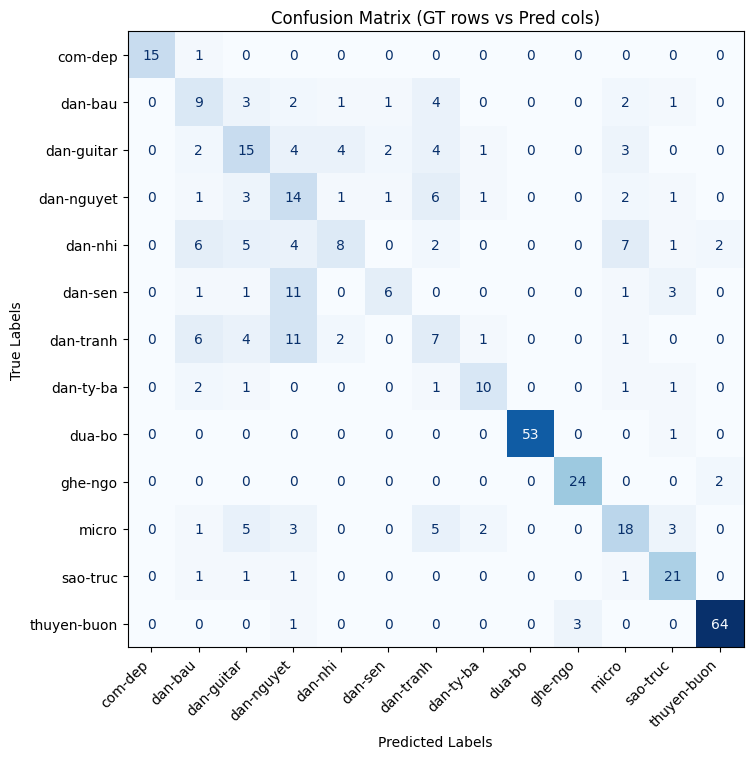

In [60]:
# Evaluate on test set
cm = evaluate_model_metrics(model, test_loader, device, train_dataset.classes, score_thresh=0.5)

In [72]:
# Visualize random test samples and presictions
def visualize_predictions(model, dataset, device, class_names, num_samples=5, score_thresh=0.5):
    """
    Randomly pick samples from dataset and visualize ground truth vs predictions.

    Args:
        model: trained Mask R-CNN
        dataset: dataset object (train_dataset / valid_dataset / test_dataset)
        device: cuda/cpu
        class_names: list of class names (with background)
        num_samples: how many random samples to show
        score_thresh: confidence threshold for predictions
    """
    model.eval()
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, target = dataset[idx]
            img_tensor = img.to(device).unsqueeze(0)

            # Run inference
            output = model(img_tensor)[0]

            # Filter predictions
            scores = output["scores"].cpu().numpy()
            keep = scores >= score_thresh

            pred_boxes = output["boxes"][keep].cpu()
            pred_labels = output["labels"][keep].cpu()
            pred_masks = output["masks"][keep].cpu().numpy()
            pred_masks = (pred_masks > 0.5).astype(np.uint8).squeeze(1)

            pred_target = {
                "boxes": pred_boxes,
                "labels": pred_labels,
                "masks": torch.as_tensor(pred_masks, dtype=torch.uint8)
            }

            print(f"\nSample {i+1}/{len(indices)} (Dataset idx={idx})")
            print(f"GT objects: {len(target['boxes'])}, Predicted: {len(pred_boxes)}")

            # Show ground truth
            print("Ground Truth:")
            visualize_sample(img, target, class_names)

            # Show predictions
            print("Predictions:")
            visualize_sample(img, pred_target, class_names)


Sample 1/5 (Dataset idx=74)
GT objects: 1, Predicted: 3
Ground Truth:


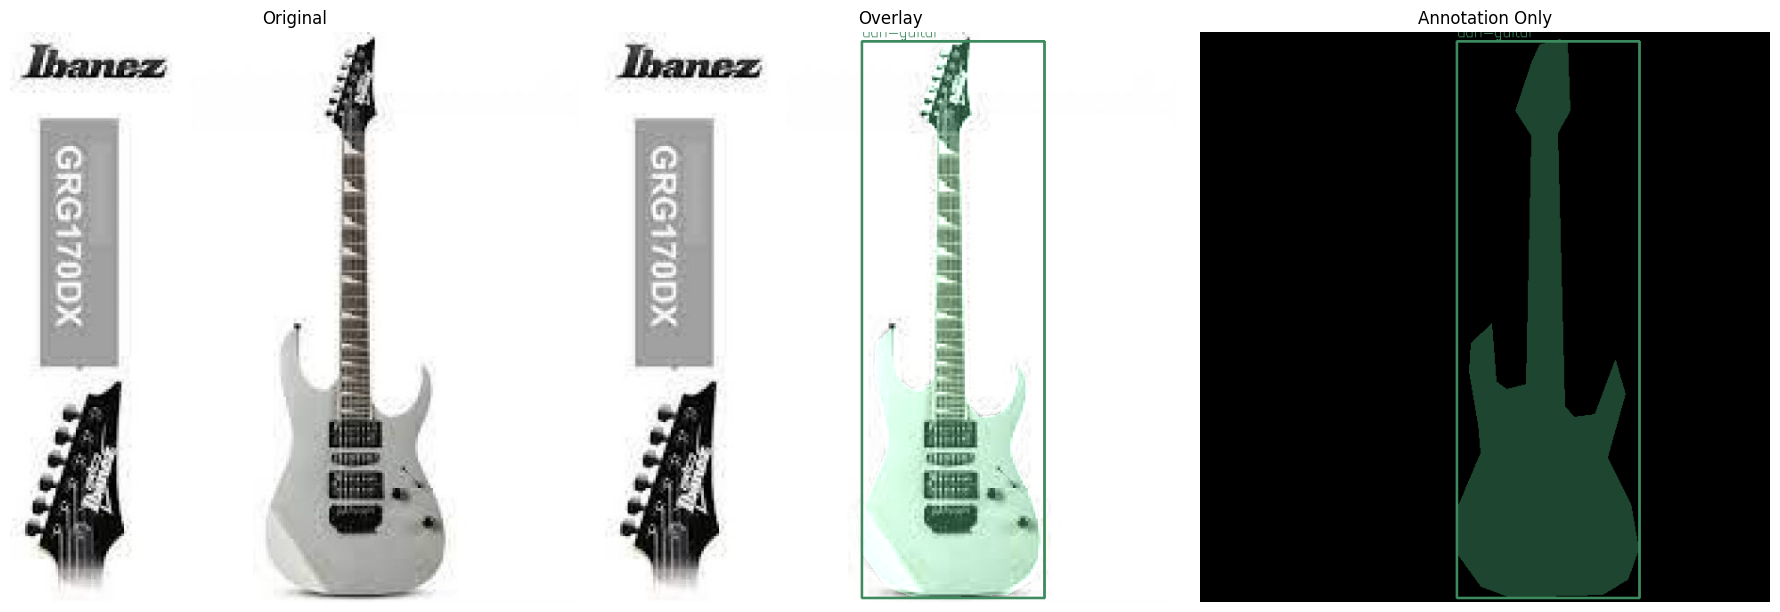

Predictions:


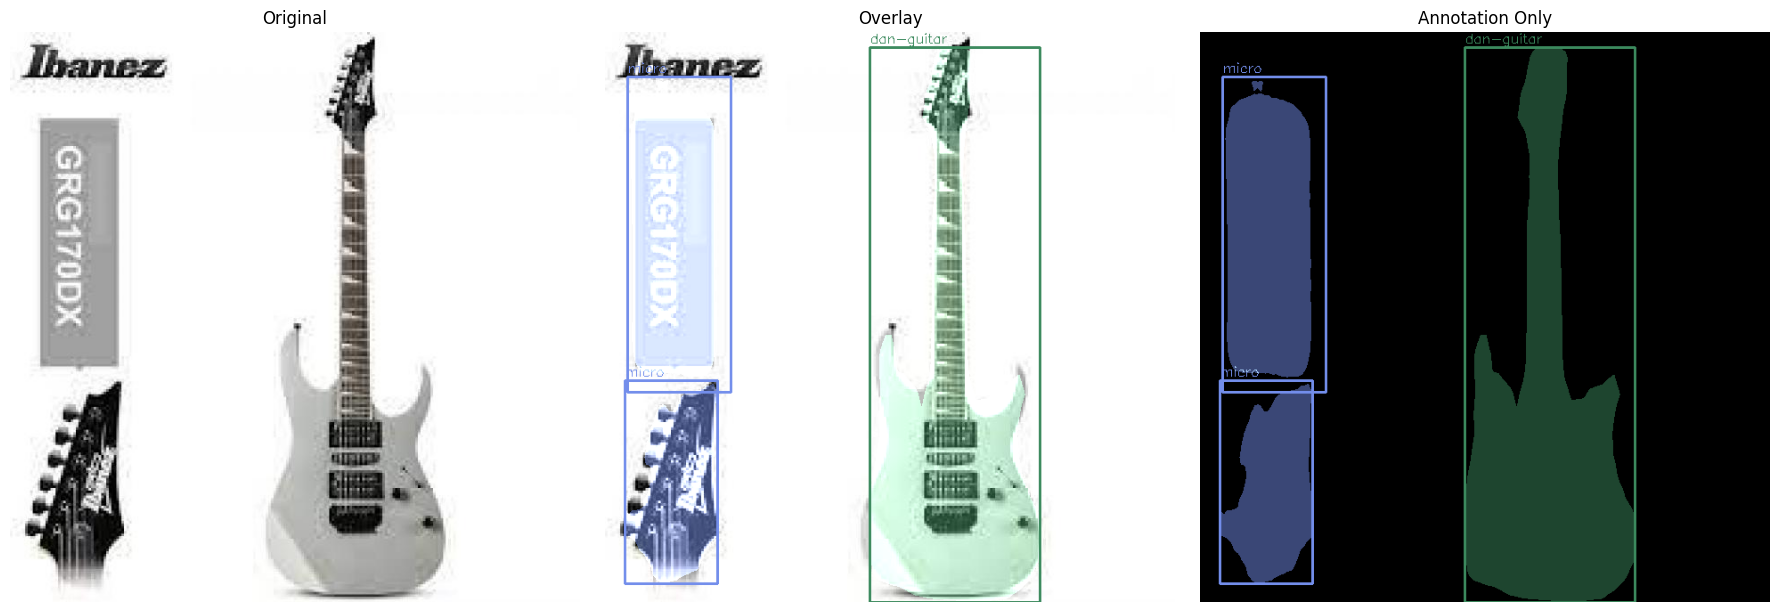


Sample 2/5 (Dataset idx=96)
GT objects: 1, Predicted: 3
Ground Truth:


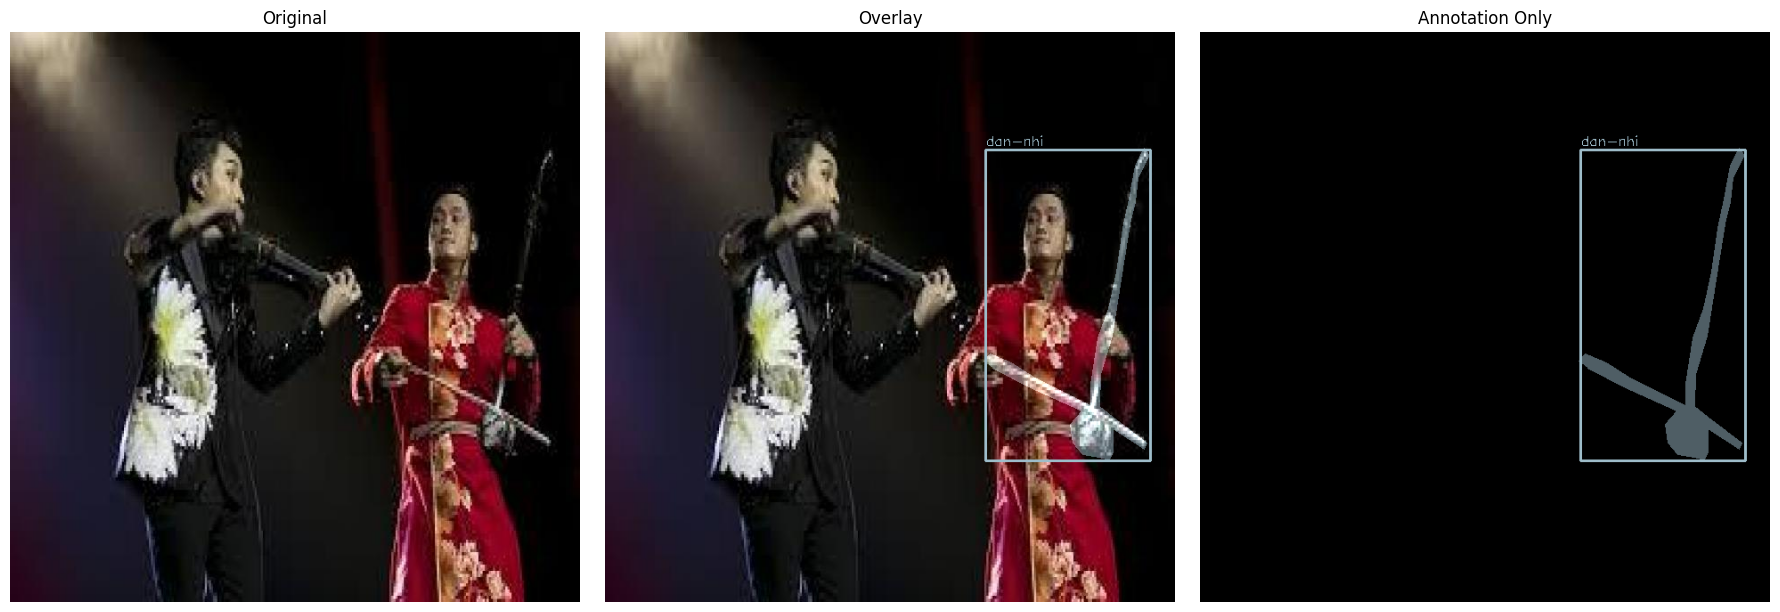

Predictions:


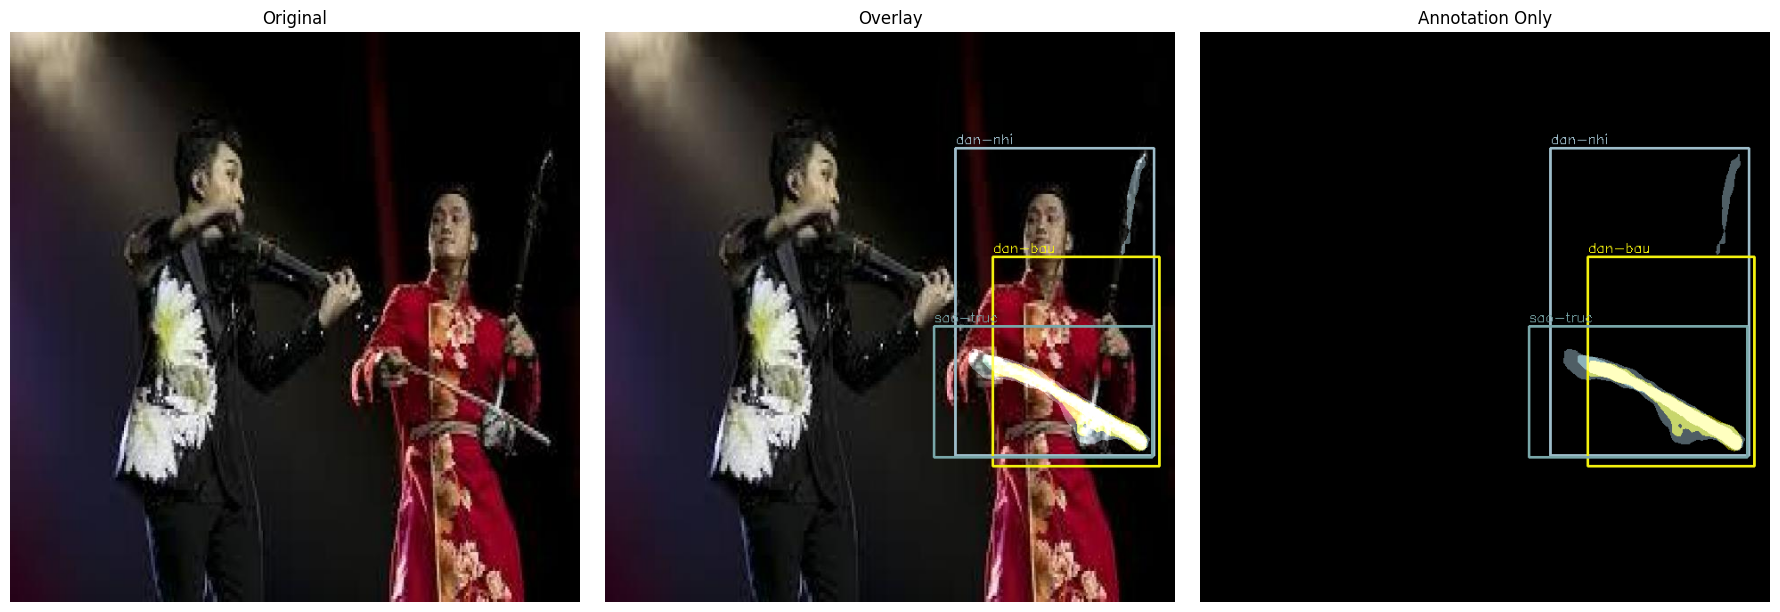


Sample 3/5 (Dataset idx=374)
GT objects: 8, Predicted: 6
Ground Truth:


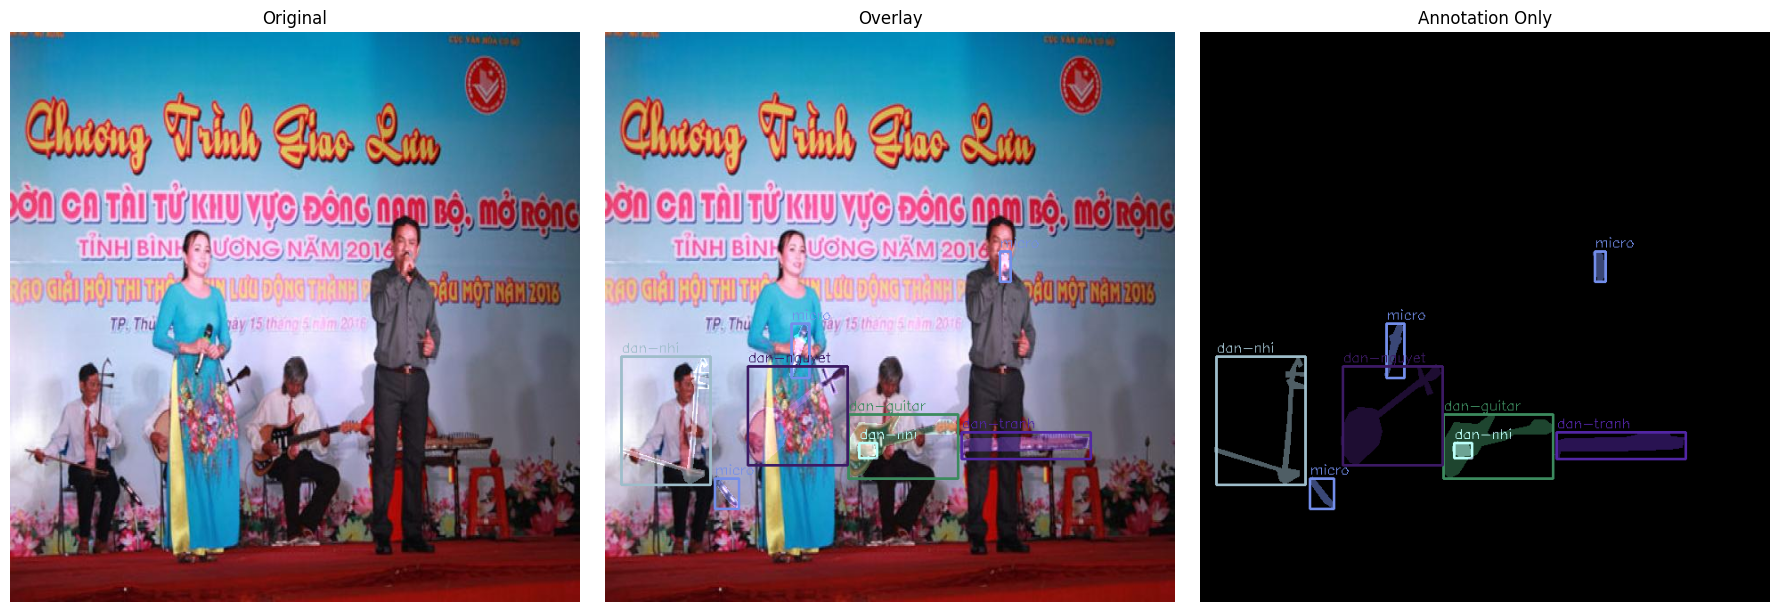

Predictions:


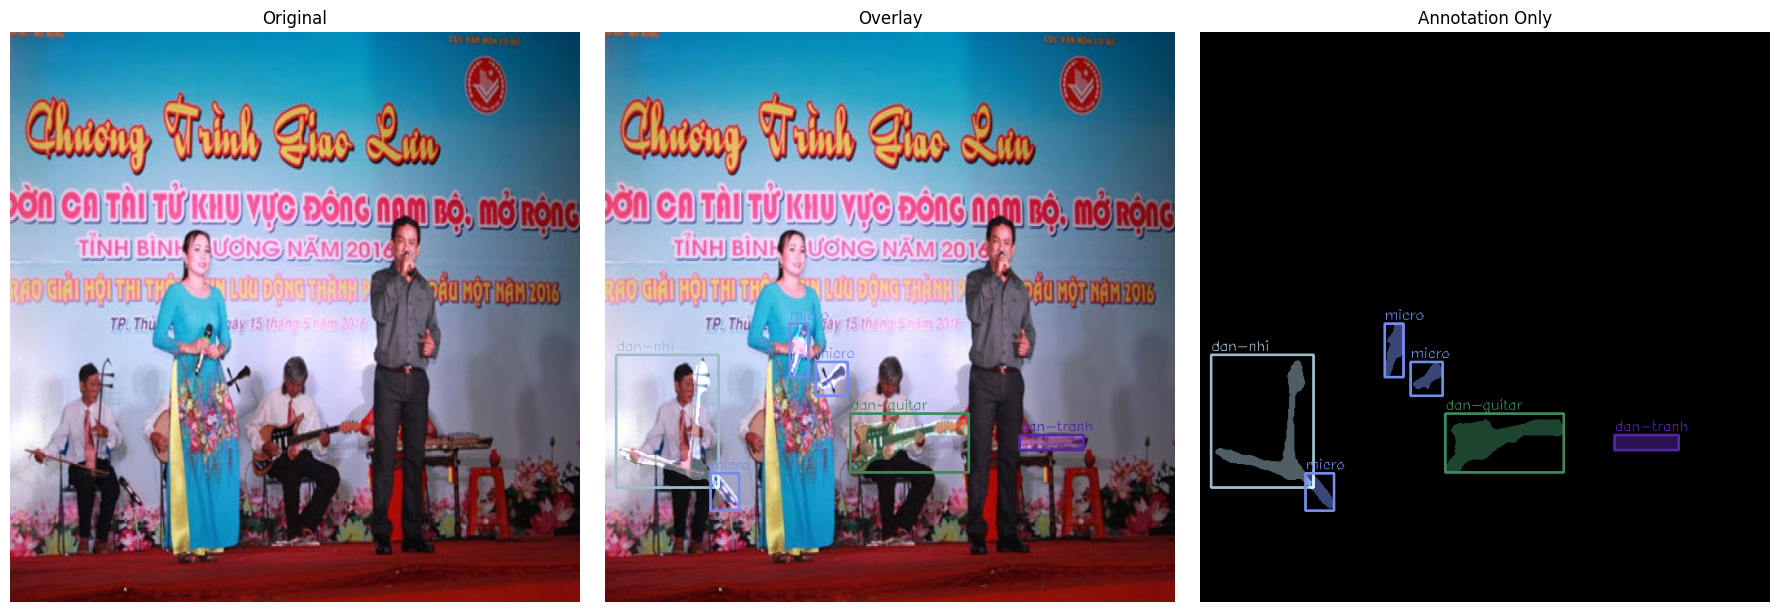


Sample 4/5 (Dataset idx=59)
GT objects: 1, Predicted: 3
Ground Truth:


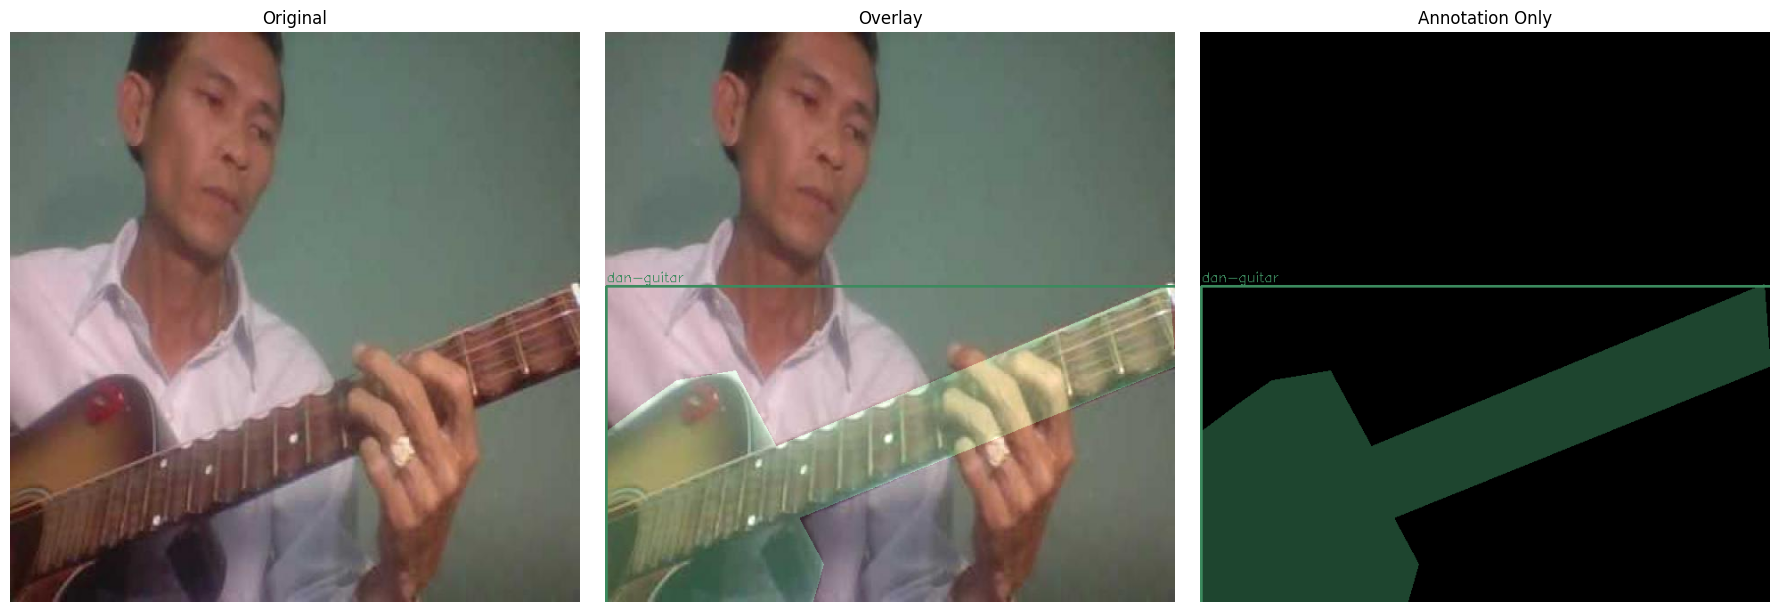

Predictions:


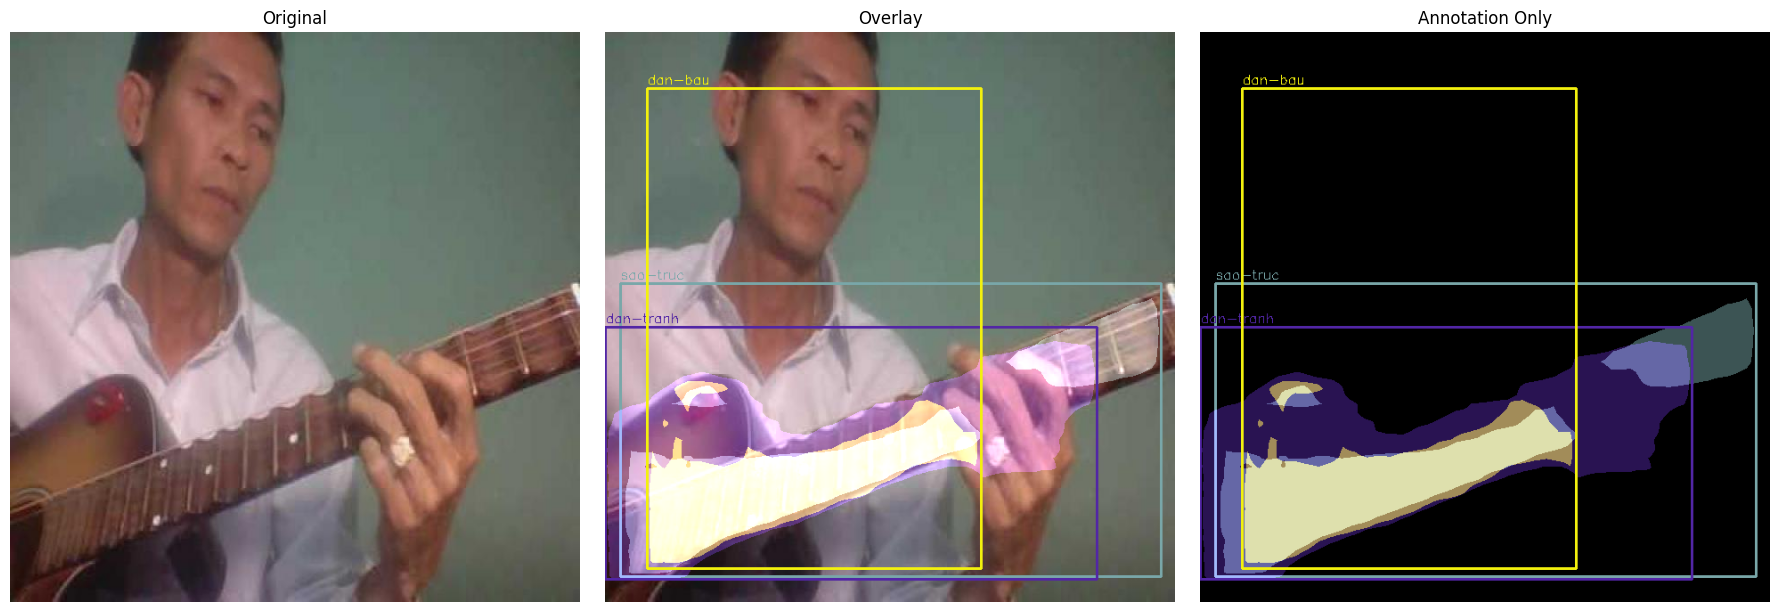


Sample 5/5 (Dataset idx=519)
GT objects: 4, Predicted: 10
Ground Truth:


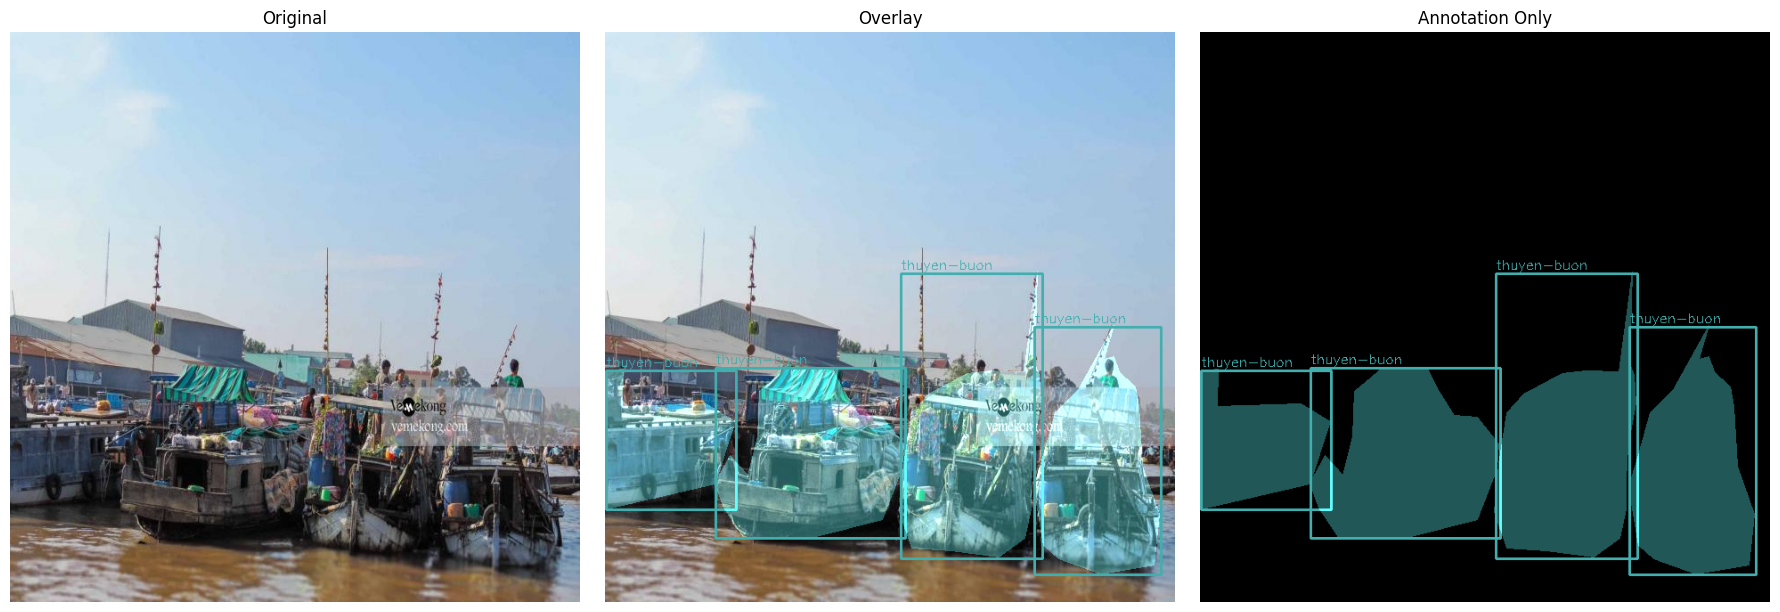

Predictions:


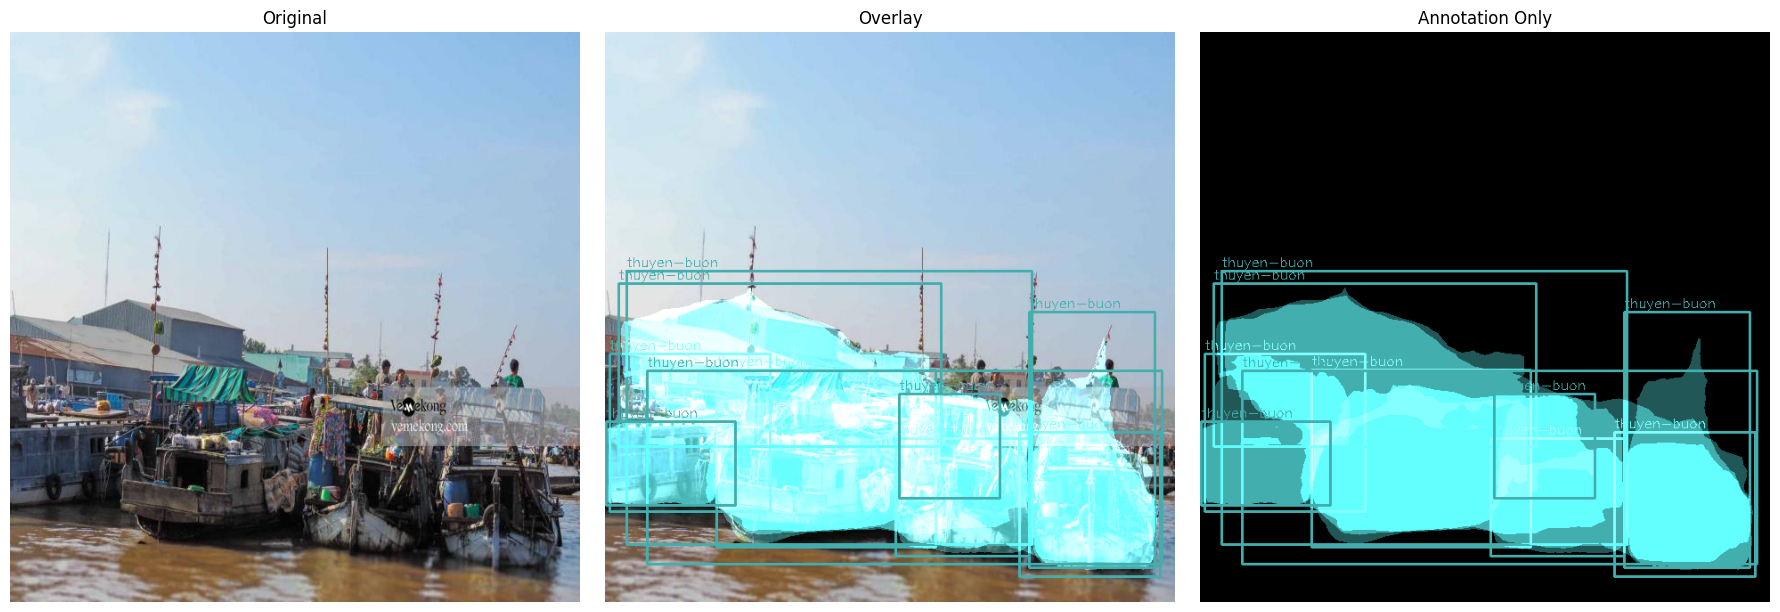

In [76]:
# Visualize predictions on test dataset
visualize_predictions(model, test_dataset, device, train_dataset.classes, num_samples=5, score_thresh=0.5)